In [11]:
import numpy as np

def train_test_split(X, y, test_size=0.2, random_state=None):
    if random_state:
        np.random.seed(random_state)
        
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    num_test_samples = int(test_size * X.shape[0])
    test_indices = indices[:num_test_samples]
    train_indices = indices[num_test_samples:]

    X_train, X_test = X.iloc[train_indices], X.iloc[test_indices]
    y_train, y_test = y.iloc[train_indices], y.iloc[test_indices]

    return X_train, X_test, y_train, y_test

In [12]:
class LassoReg:
    def __init__(self, alpha=1.0, max_iter=100, tol=0.5):
        self.alpha = alpha
        self.max_iter = max_iter
        self.tol = tol
        self.coef_ = None
        self.intercept_ = None

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.coef_ = np.zeros(n_features)
        self.intercept_ = 0.0
        Transpose = np.dot(X.T, X)

        for _ in range(self.max_iter):
            prev_coef = np.copy(self.coef_)
            prev_intercept = self.intercept_
            residuals = y - np.dot(X, self.coef_)
            self.intercept_ = np.mean(residuals) if n_samples > 1 else residuals[0]

            for j in range(n_features):
                rho_j = np.dot(X[:, j], residuals + np.dot(X, self.coef_) - X[:, j] * self.coef_[j])
                if rho_j < -self.alpha / 2:
                    self.coef_[j] = (rho_j + self.alpha / 2) / Transpose[j, j]
                elif rho_j > self.alpha / 2:
                    self.coef_[j] = (rho_j - self.alpha / 2) / Transpose[j, j]
                else:
                    self.coef_[j] = 0.0

            coef_change = np.max(np.abs(self.coef_ - prev_coef))
            intercept_change = np.abs(self.intercept_ - prev_intercept)
            if coef_change < self.tol and intercept_change < self.tol:
                break

    def predict(self, X):
        return np.dot(X, self.coef_) + self.intercept_

In [13]:
file_path = '/Users/ishikamanghwani/desktop/cardetails_csv.csv'
import pandas as pd
data = pd.read_csv(file_path)
data.head()

,name,year,km_driven,fuel,seller_type,transmission,owner,selling_price
0,Maruti 800 AC,2007,70000,Petrol,Individual,Manual,First Owner,60000
1,Maruti Wagon R LXI Minor,2007,50000,Petrol,Individual,Manual,First Owner,135000
2,Hyundai Verna 1.6 SX,2012,100000,Diesel,Individual,Manual,First Owner,600000
3,Datsun RediGO T Option,2017,46000,Petrol,Individual,Manual,First Owner,250000
4,Honda Amaze VX i-DTEC,2014,141000,Diesel,Individual,Manual,Second Owner,450000


In [14]:
data.columns

Index(['name', 'year', 'km_driven', 'fuel', 'seller_type', 'transmission',
       'owner', 'selling_price'],
      dtype='object')

In [15]:
data_encoded = pd.get_dummies(data, columns=['fuel', 'seller_type', 'transmission', 'owner'])
X = data_encoded.drop(columns=['selling_price','name'])
y = data_encoded['selling_price']
data_encoded.head()

,name,year,km_driven,selling_price,fuel_CNG,fuel_Diesel,fuel_Electric,fuel_LPG,fuel_Petrol,seller_type_Dealer,seller_type_Individual,seller_type_Trustmark Dealer,transmission_Automatic,transmission_Manual,owner_First Owner,owner_Fourth & Above Owner,owner_Second Owner,owner_Test Drive Car,owner_Third Owner
0,Maruti 800 AC,2007,70000,60000,False,False,False,False,True,False,True,False,False,True,True,False,False,False,False
1,Maruti Wagon R LXI Minor,2007,50000,135000,False,False,False,False,True,False,True,False,False,True,True,False,False,False,False
2,Hyundai Verna 1.6 SX,2012,100000,600000,False,True,False,False,False,False,True,False,False,True,True,False,False,False,False
3,Datsun RediGO T Option,2017,46000,250000,False,False,False,False,True,False,True,False,False,True,True,False,False,False,False
4,Honda Amaze VX i-DTEC,2014,141000,450000,False,True,False,False,False,False,True,False,False,True,False,False,True,False,False


<Axes: >

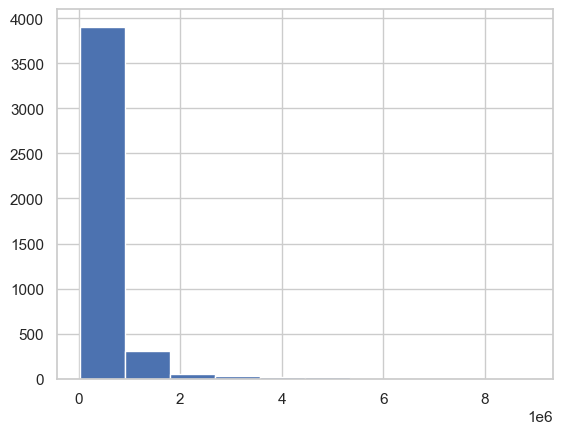

In [21]:
data['selling_price'].hist()

In [16]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest

X_df = pd.DataFrame(X)
y_df = pd.Series(y)

nan_mask_X = X_df.isna().any(axis=1)
nan_mask_y = y_df.isna()

nan_mask_combined = nan_mask_X | nan_mask_y

X_clean = X_df[~nan_mask_combined]
y_clean = y_df[~nan_mask_combined]

isolation_forest = IsolationForest(contamination=0.1, random_state=42)
outlier_mask = isolation_forest.fit_predict(X_clean) != -1

X_clean = X_clean[outlier_mask]
y_clean = y_clean[outlier_mask]

y_clean = y_clean[:X_clean.shape[0]]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_clean)
X_scaled_df = pd.DataFrame(X_scaled)

print("Original data shape:", X.shape)
print("Cleaned data shape:", X_clean.shape)
print("Scaled data shape:", X_scaled_df.shape)
print("Scaled feature shape", y_clean.shape)

Original data shape: (4340, 17)
Cleaned data shape: (3906, 17)
Scaled data shape: (3906, 17)
Scaled feature shape (3906,)


/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


In [17]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled_df, y_clean, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

print("Training data shape:", X_train.shape)
print("Validation data shape:", X_val.shape)
print("Testing data shape:", X_test.shape)
print("Training target shape:", y_train.shape)
print("Validation target shape:", y_val.shape)
print("Testing target shape:", y_test.shape)
from sklearn.metrics import mean_squared_error

Training data shape: (2500, 17)
Validation data shape: (625, 17)
Testing data shape: (781, 17)
Training target shape: (2500,)
Validation target shape: (625,)
Testing target shape: (781,)


In [18]:
X_train_np = X_train.to_numpy()
y_train_np = y_train.to_numpy()

lasso_model = LassoReg(alpha=1.0)
lasso_model.fit(X_train_np, y_train_np)

predictions = lasso_model.predict(X_test)

mse = mean_squared_error(y_test, predictions)
print("Custom Lasso Regression Mean Squared Error:", mse)

Custom Lasso Regression Mean Squared Error: 2.327355500204217e+33


In [19]:
import tensorflow as tf

model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='linear')  
])

model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(), metrics=['mean_squared_error'])

history = model.fit(X_train, y_train, epochs=1000, batch_size=100, validation_data=(X_val, y_val))

test_loss, test_mse = model.evaluate(X_test, y_test)
print(f'Test MSE for TensorFlow Model: {test_mse}')

Epoch 1/1000


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 441223741440.0000 - mean_squared_error: 441223741440.0000 - val_loss: 348314828800.0000 - val_mean_squared_error: 348314828800.0000
Epoch 2/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 556us/step - loss: 422908854272.0000 - mean_squared_error: 422908854272.0000 - val_loss: 348306767872.0000 - val_mean_squared_error: 348306767872.0000
Epoch 3/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 669us/step - loss: 429820379136.0000 - mean_squared_error: 429820379136.0000 - val_loss: 348287401984.0000 - val_mean_squared_error: 348287401984.0000
Epoch 4/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 636us/step - loss: 431389048832.0000 - mean_squared_error: 431389048832.0000 - val_loss: 348247556096.0000 - val_mean_squared_error: 348247556096.0000
Epoch 5/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 623us/step - loss: 424701100032.0000 - mean_squared_error: 424701100032.0000 - val_loss: 348174090240.0000 - val_mean_squared_error: 348174090240.0000
Epoch 6/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 59

Epoch 37/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 657us/step - loss: 320106594304.0000 - mean_squared_error: 320106594304.0000 - val_loss: 259491758080.0000 - val_mean_squared_error: 259491758080.0000
Epoch 38/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 304832970752.0000 - mean_squared_error: 304832970752.0000 - val_loss: 253658300416.0000 - val_mean_squared_error: 253658300416.0000
Epoch 39/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 657us/step - loss: 304392667136.0000 - mean_squared_error: 304392667136.0000 - val_loss: 247574216704.0000 - val_mean_squared_error: 247574216704.0000
Epoch 40/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 658us/step - loss: 304469934080.0000 - mean_squared_error: 304469934080.0000 - val_loss: 241491542016.0000 - val_mean_squared_error: 241491542016.0000
Epoch 41/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 682us/step - loss: 301136117760.0000 - mean_squared_error: 301136117760.0000 - val_loss: 235233984512.0000 - val_mean_squared_error: 235233984512.0000
Epoch 42/1000
25/25 ━━━━━

Epoch 73/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 610us/step - loss: 142961082368.0000 - mean_squared_error: 142961082368.0000 - val_loss: 99965435904.0000 - val_mean_squared_error: 99965444096.0000
Epoch 74/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 654us/step - loss: 132174929920.0000 - mean_squared_error: 132174929920.0000 - val_loss: 98538053632.0000 - val_mean_squared_error: 98538061824.0000
Epoch 75/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 609us/step - loss: 113607294976.0000 - mean_squared_error: 113607294976.0000 - val_loss: 97267974144.0000 - val_mean_squared_error: 97267974144.0000
Epoch 76/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 622us/step - loss: 200339521536.0000 - mean_squared_error: 200339521536.0000 - val_loss: 96006062080.0000 - val_mean_squared_error: 96006062080.0000
Epoch 77/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 655us/step - loss: 196585979904.0000 - mean_squared_error: 196585979904.0000 - val_loss: 94899175424.0000 - val_mean_squared_error: 94899175424.0000
Epoch 78/1000
25/25 ━━━━━━━━━━━━━━━

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 749us/step - loss: 116772913152.0000 - mean_squared_error: 116772913152.0000 - val_loss: 81525710848.0000 - val_mean_squared_error: 81525710848.0000
Epoch 110/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step - loss: 126828118016.0000 - mean_squared_error: 126828118016.0000 - val_loss: 81304928256.0000 - val_mean_squared_error: 81304928256.0000
Epoch 111/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step - loss: 127099805696.0000 - mean_squared_error: 127099805696.0000 - val_loss: 81104642048.0000 - val_mean_squared_error: 81104642048.0000
Epoch 112/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step - loss: 120416862208.0000 - mean_squared_error: 120416862208.0000 - val_loss: 80900685824.0000 - val_mean_squared_error: 80900685824.0000
Epoch 113/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 668us/step - loss: 102054174720.0000 - mean_squared_error: 102054174720.0000 - val_loss: 80604782592.0000 - val_mean_squared_error: 80604782592.0000
Epoch 114/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step - loss: 191445893120.0000 - mean_squared_error: 191445893120.0000 - val_loss: 75186143232.0000 - val_mean_squared_error: 75186135040.0000
Epoch 146/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 618us/step - loss: 111620423680.0000 - mean_squared_error: 111620423680.0000 - val_loss: 75005280256.0000 - val_mean_squared_error: 75005280256.0000
Epoch 147/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 615us/step - loss: 96592953344.0000 - mean_squared_error: 96592953344.0000 - val_loss: 74808385536.0000 - val_mean_squared_error: 74808385536.0000
Epoch 148/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 620us/step - loss: 122117922816.0000 - mean_squared_error: 122117922816.0000 - val_loss: 74777477120.0000 - val_mean_squared_error: 74777477120.0000
Epoch 149/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 633us/step - loss: 136613830656.0000 - mean_squared_error: 136613830656.0000 - val_loss: 74689994752.0000 - val_mean_squared_error: 74689994752.0000
Epoch 150/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 58

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 635us/step - loss: 131079954432.0000 - mean_squared_error: 131079954432.0000 - val_loss: 71913218048.0000 - val_mean_squared_error: 71913218048.0000
Epoch 182/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 607us/step - loss: 107005911040.0000 - mean_squared_error: 107005911040.0000 - val_loss: 71797497856.0000 - val_mean_squared_error: 71797497856.0000
Epoch 183/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 630us/step - loss: 88113348608.0000 - mean_squared_error: 88113348608.0000 - val_loss: 71694254080.0000 - val_mean_squared_error: 71694254080.0000
Epoch 184/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 615us/step - loss: 110339629056.0000 - mean_squared_error: 110339629056.0000 - val_loss: 71772676096.0000 - val_mean_squared_error: 71772676096.0000
Epoch 185/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 620us/step - loss: 111014789120.0000 - mean_squared_error: 111014789120.0000 - val_loss: 71687602176.0000 - val_mean_squared_error: 71687602176.0000
Epoch 186/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 63

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 584us/step - loss: 104888532992.0000 - mean_squared_error: 104888532992.0000 - val_loss: 70202302464.0000 - val_mean_squared_error: 70202302464.0000
Epoch 218/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 646us/step - loss: 126751571968.0000 - mean_squared_error: 126751571968.0000 - val_loss: 70133792768.0000 - val_mean_squared_error: 70133792768.0000
Epoch 219/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 628us/step - loss: 98392940544.0000 - mean_squared_error: 98392940544.0000 - val_loss: 70052970496.0000 - val_mean_squared_error: 70052970496.0000
Epoch 220/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 603us/step - loss: 127508160512.0000 - mean_squared_error: 127508160512.0000 - val_loss: 70085894144.0000 - val_mean_squared_error: 70085894144.0000
Epoch 221/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 627us/step - loss: 106530734080.0000 - mean_squared_error: 106530734080.0000 - val_loss: 69987442688.0000 - val_mean_squared_error: 69987450880.0000
Epoch 222/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 57

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 616us/step - loss: 134090866688.0000 - mean_squared_error: 134090866688.0000 - val_loss: 68637290496.0000 - val_mean_squared_error: 68637290496.0000
Epoch 254/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 620us/step - loss: 140890587136.0000 - mean_squared_error: 140890587136.0000 - val_loss: 68645609472.0000 - val_mean_squared_error: 68645609472.0000
Epoch 255/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 588us/step - loss: 151263281152.0000 - mean_squared_error: 151263281152.0000 - val_loss: 68583694336.0000 - val_mean_squared_error: 68583694336.0000
Epoch 256/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 623us/step - loss: 113015595008.0000 - mean_squared_error: 113015595008.0000 - val_loss: 68483923968.0000 - val_mean_squared_error: 68483923968.0000
Epoch 257/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 613us/step - loss: 87218479104.0000 - mean_squared_error: 87218479104.0000 - val_loss: 68385308672.0000 - val_mean_squared_error: 68385308672.0000
Epoch 258/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 63

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 641us/step - loss: 98306162688.0000 - mean_squared_error: 98306162688.0000 - val_loss: 67179991040.0000 - val_mean_squared_error: 67179991040.0000
Epoch 290/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 608us/step - loss: 146105090048.0000 - mean_squared_error: 146105090048.0000 - val_loss: 67297701888.0000 - val_mean_squared_error: 67297701888.0000
Epoch 291/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 630us/step - loss: 92120416256.0000 - mean_squared_error: 92120416256.0000 - val_loss: 67138412544.0000 - val_mean_squared_error: 67138412544.0000
Epoch 292/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 599us/step - loss: 176206364672.0000 - mean_squared_error: 176206364672.0000 - val_loss: 67143987200.0000 - val_mean_squared_error: 67143987200.0000
Epoch 293/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 628us/step - loss: 121112936448.0000 - mean_squared_error: 121112936448.0000 - val_loss: 67072208896.0000 - val_mean_squared_error: 67072208896.0000
Epoch 294/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 602u

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 601us/step - loss: 132257996800.0000 - mean_squared_error: 132257996800.0000 - val_loss: 65992998912.0000 - val_mean_squared_error: 65992998912.0000
Epoch 326/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 606us/step - loss: 100954791936.0000 - mean_squared_error: 100954791936.0000 - val_loss: 65936625664.0000 - val_mean_squared_error: 65936625664.0000
Epoch 327/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 613us/step - loss: 169653780480.0000 - mean_squared_error: 169653780480.0000 - val_loss: 65879457792.0000 - val_mean_squared_error: 65879457792.0000
Epoch 328/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 602us/step - loss: 92208971776.0000 - mean_squared_error: 92208971776.0000 - val_loss: 65862127616.0000 - val_mean_squared_error: 65862127616.0000
Epoch 329/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 601us/step - loss: 111799058432.0000 - mean_squared_error: 111799058432.0000 - val_loss: 65878831104.0000 - val_mean_squared_error: 65878831104.0000
Epoch 330/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 60

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 589us/step - loss: 83464667136.0000 - mean_squared_error: 83464667136.0000 - val_loss: 64875245568.0000 - val_mean_squared_error: 64875245568.0000
Epoch 362/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 611us/step - loss: 107445583872.0000 - mean_squared_error: 107445583872.0000 - val_loss: 64932229120.0000 - val_mean_squared_error: 64932229120.0000
Epoch 363/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 593us/step - loss: 105828573184.0000 - mean_squared_error: 105828573184.0000 - val_loss: 64870191104.0000 - val_mean_squared_error: 64870191104.0000
Epoch 364/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 624us/step - loss: 115621814272.0000 - mean_squared_error: 115621814272.0000 - val_loss: 64844697600.0000 - val_mean_squared_error: 64844697600.0000
Epoch 365/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 606us/step - loss: 140779159552.0000 - mean_squared_error: 140779159552.0000 - val_loss: 64847683584.0000 - val_mean_squared_error: 64847683584.0000
Epoch 366/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 59

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 626us/step - loss: 96381296640.0000 - mean_squared_error: 96381296640.0000 - val_loss: 63959101440.0000 - val_mean_squared_error: 63959101440.0000
Epoch 398/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 638us/step - loss: 86794944512.0000 - mean_squared_error: 86794944512.0000 - val_loss: 63947915264.0000 - val_mean_squared_error: 63947915264.0000
Epoch 399/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 616us/step - loss: 101356158976.0000 - mean_squared_error: 101356158976.0000 - val_loss: 63983747072.0000 - val_mean_squared_error: 63983747072.0000
Epoch 400/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 659us/step - loss: 119307378688.0000 - mean_squared_error: 119307378688.0000 - val_loss: 63932555264.0000 - val_mean_squared_error: 63932555264.0000
Epoch 401/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 617us/step - loss: 121071935488.0000 - mean_squared_error: 121071935488.0000 - val_loss: 63855968256.0000 - val_mean_squared_error: 63855968256.0000
Epoch 402/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 631u

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 615us/step - loss: 128431538176.0000 - mean_squared_error: 128431538176.0000 - val_loss: 63245971456.0000 - val_mean_squared_error: 63245971456.0000
Epoch 434/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 613us/step - loss: 107249000448.0000 - mean_squared_error: 107249000448.0000 - val_loss: 63194685440.0000 - val_mean_squared_error: 63194685440.0000
Epoch 435/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 589us/step - loss: 74343514112.0000 - mean_squared_error: 74343514112.0000 - val_loss: 63018934272.0000 - val_mean_squared_error: 63018934272.0000
Epoch 436/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 631us/step - loss: 94142832640.0000 - mean_squared_error: 94142832640.0000 - val_loss: 63137951744.0000 - val_mean_squared_error: 63137959936.0000
Epoch 437/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 620us/step - loss: 119806754816.0000 - mean_squared_error: 119806754816.0000 - val_loss: 63136247808.0000 - val_mean_squared_error: 63136247808.0000
Epoch 438/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 601u

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 608us/step - loss: 95880912896.0000 - mean_squared_error: 95880912896.0000 - val_loss: 62563991552.0000 - val_mean_squared_error: 62563991552.0000
Epoch 470/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 596us/step - loss: 105900441600.0000 - mean_squared_error: 105900441600.0000 - val_loss: 62587760640.0000 - val_mean_squared_error: 62587760640.0000
Epoch 471/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 596us/step - loss: 112793034752.0000 - mean_squared_error: 112793034752.0000 - val_loss: 62564118528.0000 - val_mean_squared_error: 62564118528.0000
Epoch 472/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 633us/step - loss: 164062511104.0000 - mean_squared_error: 164062511104.0000 - val_loss: 62504189952.0000 - val_mean_squared_error: 62504189952.0000
Epoch 473/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 619us/step - loss: 98484682752.0000 - mean_squared_error: 98484682752.0000 - val_loss: 62514626560.0000 - val_mean_squared_error: 62514626560.0000
Epoch 474/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 620u

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 610us/step - loss: 109211770880.0000 - mean_squared_error: 109211770880.0000 - val_loss: 62071357440.0000 - val_mean_squared_error: 62071357440.0000
Epoch 506/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 611us/step - loss: 101898346496.0000 - mean_squared_error: 101898346496.0000 - val_loss: 61988925440.0000 - val_mean_squared_error: 61988925440.0000
Epoch 507/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 595us/step - loss: 89132294144.0000 - mean_squared_error: 89132294144.0000 - val_loss: 62011396096.0000 - val_mean_squared_error: 62011396096.0000
Epoch 508/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 619us/step - loss: 114053652480.0000 - mean_squared_error: 114053652480.0000 - val_loss: 61977432064.0000 - val_mean_squared_error: 61977432064.0000
Epoch 509/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 617us/step - loss: 91433500672.0000 - mean_squared_error: 91433500672.0000 - val_loss: 61945294848.0000 - val_mean_squared_error: 61945294848.0000
Epoch 510/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 626u

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 654us/step - loss: 155449262080.0000 - mean_squared_error: 155449262080.0000 - val_loss: 61612613632.0000 - val_mean_squared_error: 61612621824.0000
Epoch 542/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 687us/step - loss: 94269235200.0000 - mean_squared_error: 94269235200.0000 - val_loss: 61593493504.0000 - val_mean_squared_error: 61593493504.0000
Epoch 543/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step - loss: 89721954304.0000 - mean_squared_error: 89721954304.0000 - val_loss: 61557129216.0000 - val_mean_squared_error: 61557129216.0000
Epoch 544/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 674us/step - loss: 100124712960.0000 - mean_squared_error: 100124712960.0000 - val_loss: 61588086784.0000 - val_mean_squared_error: 61588086784.0000
Epoch 545/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 685us/step - loss: 111882452992.0000 - mean_squared_error: 111882452992.0000 - val_loss: 61602480128.0000 - val_mean_squared_error: 61602480128.0000
Epoch 546/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 645u

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 674us/step - loss: 85545951232.0000 - mean_squared_error: 85545951232.0000 - val_loss: 61208162304.0000 - val_mean_squared_error: 61208162304.0000
Epoch 578/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 629us/step - loss: 87877271552.0000 - mean_squared_error: 87877271552.0000 - val_loss: 61215834112.0000 - val_mean_squared_error: 61215834112.0000
Epoch 579/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 669us/step - loss: 97783291904.0000 - mean_squared_error: 97783291904.0000 - val_loss: 61209403392.0000 - val_mean_squared_error: 61209403392.0000
Epoch 580/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 662us/step - loss: 95583797248.0000 - mean_squared_error: 95583797248.0000 - val_loss: 61207531520.0000 - val_mean_squared_error: 61207531520.0000
Epoch 581/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 610us/step - loss: 96512040960.0000 - mean_squared_error: 96512040960.0000 - val_loss: 61142831104.0000 - val_mean_squared_error: 61142831104.0000
Epoch 582/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 674us/step - loss: 93846224896.0000 - mean_squared_error: 93846224896.0000 - val_loss: 60971806720.0000 - val_mean_squared_error: 60971806720.0000
Epoch 614/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 658us/step - loss: 112628924416.0000 - mean_squared_error: 112628924416.0000 - val_loss: 60945920000.0000 - val_mean_squared_error: 60945928192.0000
Epoch 615/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 670us/step - loss: 106844676096.0000 - mean_squared_error: 106844676096.0000 - val_loss: 60885061632.0000 - val_mean_squared_error: 60885061632.0000
Epoch 616/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 678us/step - loss: 94712135680.0000 - mean_squared_error: 94712135680.0000 - val_loss: 60904849408.0000 - val_mean_squared_error: 60904849408.0000
Epoch 617/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 644us/step - loss: 91672313856.0000 - mean_squared_error: 91672313856.0000 - val_loss: 60900139008.0000 - val_mean_squared_error: 60900139008.0000
Epoch 618/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 685us/

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 645us/step - loss: 95011160064.0000 - mean_squared_error: 95011160064.0000 - val_loss: 60644306944.0000 - val_mean_squared_error: 60644306944.0000
Epoch 650/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 636us/step - loss: 86402818048.0000 - mean_squared_error: 86402818048.0000 - val_loss: 60596875264.0000 - val_mean_squared_error: 60596875264.0000
Epoch 651/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 603us/step - loss: 176154148864.0000 - mean_squared_error: 176154148864.0000 - val_loss: 60631904256.0000 - val_mean_squared_error: 60631904256.0000
Epoch 652/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 650us/step - loss: 92721987584.0000 - mean_squared_error: 92721987584.0000 - val_loss: 60607684608.0000 - val_mean_squared_error: 60607684608.0000
Epoch 653/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 119236141056.0000 - mean_squared_error: 119236141056.0000 - val_loss: 60626276352.0000 - val_mean_squared_error: 60626276352.0000
Epoch 654/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 663us/

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 71184924672.0000 - mean_squared_error: 71184924672.0000 - val_loss: 60315783168.0000 - val_mean_squared_error: 60315783168.0000
Epoch 686/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step - loss: 88894840832.0000 - mean_squared_error: 88894840832.0000 - val_loss: 60436566016.0000 - val_mean_squared_error: 60436566016.0000
Epoch 687/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 667us/step - loss: 90929807360.0000 - mean_squared_error: 90929807360.0000 - val_loss: 60352090112.0000 - val_mean_squared_error: 60352090112.0000
Epoch 688/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 664us/step - loss: 76592463872.0000 - mean_squared_error: 76592463872.0000 - val_loss: 60280528896.0000 - val_mean_squared_error: 60280528896.0000
Epoch 689/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 677us/step - loss: 90441056256.0000 - mean_squared_error: 90441056256.0000 - val_loss: 60369645568.0000 - val_mean_squared_error: 60369645568.0000
Epoch 690/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 661us/step

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 667us/step - loss: 98382995456.0000 - mean_squared_error: 98382995456.0000 - val_loss: 60164313088.0000 - val_mean_squared_error: 60164313088.0000
Epoch 722/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 673us/step - loss: 99455229952.0000 - mean_squared_error: 99455229952.0000 - val_loss: 60160438272.0000 - val_mean_squared_error: 60160438272.0000
Epoch 723/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 656us/step - loss: 84031766528.0000 - mean_squared_error: 84031766528.0000 - val_loss: 60177342464.0000 - val_mean_squared_error: 60177342464.0000
Epoch 724/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 649us/step - loss: 117691072512.0000 - mean_squared_error: 117691072512.0000 - val_loss: 60176764928.0000 - val_mean_squared_error: 60176764928.0000
Epoch 725/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 649us/step - loss: 97897537536.0000 - mean_squared_error: 97897537536.0000 - val_loss: 60169043968.0000 - val_mean_squared_error: 60169043968.0000
Epoch 726/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 658us/st

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 626us/step - loss: 110375985152.0000 - mean_squared_error: 110375985152.0000 - val_loss: 60019335168.0000 - val_mean_squared_error: 60019335168.0000
Epoch 758/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 661us/step - loss: 134186999808.0000 - mean_squared_error: 134186999808.0000 - val_loss: 60048932864.0000 - val_mean_squared_error: 60048932864.0000
Epoch 759/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 647us/step - loss: 111543271424.0000 - mean_squared_error: 111543271424.0000 - val_loss: 60001050624.0000 - val_mean_squared_error: 60001050624.0000
Epoch 760/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 669us/step - loss: 159048482816.0000 - mean_squared_error: 159048482816.0000 - val_loss: 60003766272.0000 - val_mean_squared_error: 60003766272.0000
Epoch 761/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 639us/step - loss: 90733068288.0000 - mean_squared_error: 90733068288.0000 - val_loss: 59925442560.0000 - val_mean_squared_error: 59925442560.0000
Epoch 762/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 63

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 647us/step - loss: 78549991424.0000 - mean_squared_error: 78549991424.0000 - val_loss: 59833888768.0000 - val_mean_squared_error: 59833888768.0000
Epoch 794/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 650us/step - loss: 89024028672.0000 - mean_squared_error: 89024028672.0000 - val_loss: 59843690496.0000 - val_mean_squared_error: 59843690496.0000
Epoch 795/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 598us/step - loss: 132491280384.0000 - mean_squared_error: 132491280384.0000 - val_loss: 59853709312.0000 - val_mean_squared_error: 59853709312.0000
Epoch 796/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 615us/step - loss: 94592606208.0000 - mean_squared_error: 94592606208.0000 - val_loss: 59818504192.0000 - val_mean_squared_error: 59818504192.0000
Epoch 797/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 607us/step - loss: 97696088064.0000 - mean_squared_error: 97696088064.0000 - val_loss: 59855212544.0000 - val_mean_squared_error: 59855212544.0000
Epoch 798/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 602us/st

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 669us/step - loss: 106337812480.0000 - mean_squared_error: 106337812480.0000 - val_loss: 59693072384.0000 - val_mean_squared_error: 59693072384.0000
Epoch 830/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 636us/step - loss: 91369816064.0000 - mean_squared_error: 91369816064.0000 - val_loss: 59692118016.0000 - val_mean_squared_error: 59692118016.0000
Epoch 831/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 635us/step - loss: 140099993600.0000 - mean_squared_error: 140099993600.0000 - val_loss: 59719176192.0000 - val_mean_squared_error: 59719176192.0000
Epoch 832/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 637us/step - loss: 135739277312.0000 - mean_squared_error: 135739277312.0000 - val_loss: 59765092352.0000 - val_mean_squared_error: 59765092352.0000
Epoch 833/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 648us/step - loss: 116580302848.0000 - mean_squared_error: 116580302848.0000 - val_loss: 59687624704.0000 - val_mean_squared_error: 59687624704.0000
Epoch 834/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 64

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 677us/step - loss: 95149465600.0000 - mean_squared_error: 95149465600.0000 - val_loss: 59592806400.0000 - val_mean_squared_error: 59592806400.0000
Epoch 866/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 683us/step - loss: 138803036160.0000 - mean_squared_error: 138803036160.0000 - val_loss: 59533475840.0000 - val_mean_squared_error: 59533475840.0000
Epoch 867/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 681us/step - loss: 87509393408.0000 - mean_squared_error: 87509393408.0000 - val_loss: 59522011136.0000 - val_mean_squared_error: 59522011136.0000
Epoch 868/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step - loss: 93761126400.0000 - mean_squared_error: 93761126400.0000 - val_loss: 59514806272.0000 - val_mean_squared_error: 59514806272.0000
Epoch 869/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 663us/step - loss: 86234103808.0000 - mean_squared_error: 86234103808.0000 - val_loss: 59578617856.0000 - val_mean_squared_error: 59578617856.0000
Epoch 870/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 658us/st

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 667us/step - loss: 88090214400.0000 - mean_squared_error: 88090214400.0000 - val_loss: 59449741312.0000 - val_mean_squared_error: 59449741312.0000
Epoch 902/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 687us/step - loss: 87959666688.0000 - mean_squared_error: 87959666688.0000 - val_loss: 59504222208.0000 - val_mean_squared_error: 59504222208.0000
Epoch 903/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 667us/step - loss: 146342133760.0000 - mean_squared_error: 146342133760.0000 - val_loss: 59469037568.0000 - val_mean_squared_error: 59469037568.0000
Epoch 904/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 645us/step - loss: 93413425152.0000 - mean_squared_error: 93413425152.0000 - val_loss: 59449057280.0000 - val_mean_squared_error: 59449065472.0000
Epoch 905/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 671us/step - loss: 154347012096.0000 - mean_squared_error: 154347012096.0000 - val_loss: 59508887552.0000 - val_mean_squared_error: 59508887552.0000
Epoch 906/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 671us/

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 587us/step - loss: 76495732736.0000 - mean_squared_error: 76495732736.0000 - val_loss: 59279319040.0000 - val_mean_squared_error: 59279319040.0000
Epoch 938/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 629us/step - loss: 102171451392.0000 - mean_squared_error: 102171451392.0000 - val_loss: 59341209600.0000 - val_mean_squared_error: 59341209600.0000
Epoch 939/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 635us/step - loss: 109126230016.0000 - mean_squared_error: 109126230016.0000 - val_loss: 59339223040.0000 - val_mean_squared_error: 59339223040.0000
Epoch 940/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 633us/step - loss: 176360718336.0000 - mean_squared_error: 176360718336.0000 - val_loss: 59391619072.0000 - val_mean_squared_error: 59391619072.0000
Epoch 941/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 644us/step - loss: 126379638784.0000 - mean_squared_error: 126379638784.0000 - val_loss: 59339321344.0000 - val_mean_squared_error: 59339321344.0000
Epoch 942/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 63

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 636us/step - loss: 113752227840.0000 - mean_squared_error: 113752227840.0000 - val_loss: 59258535936.0000 - val_mean_squared_error: 59258535936.0000
Epoch 974/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 610us/step - loss: 76772212736.0000 - mean_squared_error: 76772212736.0000 - val_loss: 59274407936.0000 - val_mean_squared_error: 59274407936.0000
Epoch 975/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 610us/step - loss: 74178183168.0000 - mean_squared_error: 74178183168.0000 - val_loss: 59234664448.0000 - val_mean_squared_error: 59234664448.0000
Epoch 976/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 628us/step - loss: 85933203456.0000 - mean_squared_error: 85933203456.0000 - val_loss: 59273707520.0000 - val_mean_squared_error: 59273707520.0000
Epoch 977/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 629us/step - loss: 136137457664.0000 - mean_squared_error: 136137457664.0000 - val_loss: 59211292672.0000 - val_mean_squared_error: 59211292672.0000
Epoch 978/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 630us/

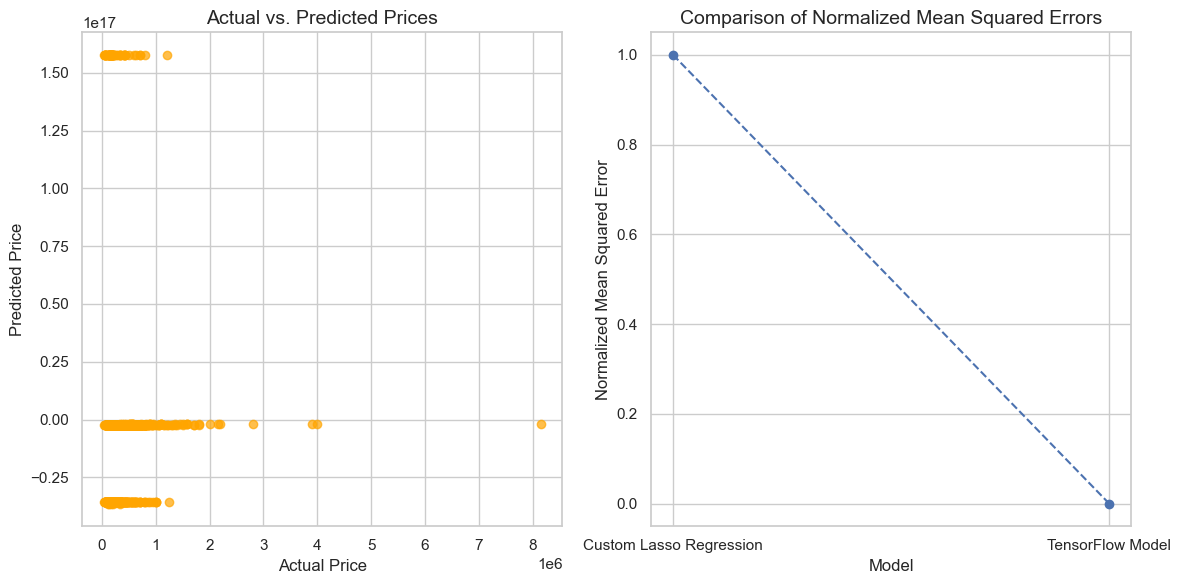

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
max_mse = max(mse, test_mse)
normalized_mse_custom = mse / max_mse
normalized_mse_tf = test_mse / max_mse

#prices
plt.subplot(1, 2, 1)
plt.scatter(y_test, predictions, color='orange', alpha=0.7)
plt.xlabel('Actual Price', fontsize=12)
plt.ylabel('Predicted Price', fontsize=12)
plt.title('Actual vs. Predicted Prices', fontsize=14)

#mse
plt.subplot(1, 2, 2)
plt.plot(['Custom Lasso Regression', 'TensorFlow Model'], [normalized_mse_custom, normalized_mse_tf], marker='o', linestyle='--')
plt.xlabel('Model', fontsize=12)
plt.ylabel('Normalized Mean Squared Error', fontsize=12)
plt.title('Comparison of Normalized Mean Squared Errors', fontsize=14)
plt.grid(True)

plt.tight_layout()
plt.show()